In [1]:
#Robert Walters CSCI 6620

import numpy as np
import keras
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from keras_tqdm import TQDMNotebookCallback
from keras.models import model_from_json

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

import myencdecfuncs as my #this is a module I created for this project 

Using TensorFlow backend.


In [2]:
#####For Demo
temparr = my.quickCreate(2,1)
print(temparr[0], "\n\n---------\n\n", temparr[1])

[[30 14  5 31 35 24  1 18  5 27]
 [30 13 29  2 33  7 33 30 31  1]] 

---------

 [[ 0  1  5  5 14 18 24 27 30 31]
 [ 0  1  2  7 13 29 30 30 31 33]]


In [3]:
#36, 36, 128
def buildModels(encin, decin, outnum, hiddenUnits):
    #some quick math
    #if the arrays are the same, I'm putting the padval at start and end of the input arrays
    if (encin == outnum):
        encin += 1
        decin += 1
        outnum += 1
   #this is the training model 
    #build training encoder
    encoder_inputs = keras.layers.Input(shape=(None, encin))
    encoder = keras.layers.LSTM(hiddenUnits, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #build training decoder
    decoder_inputs = keras.layers.Input(shape=(None, decin))
    decoder_lstm = keras.layers.LSTM(hiddenUnits, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(outnum, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    fmodel = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
   #these are the separate inference models 
    #build inference encoder
    encoder_model = keras.models.Model(encoder_inputs, encoder_states)
    #build inference decoder
    decoder_state_input_h = keras.layers.Input(shape=(hiddenUnits,))
    decoder_state_input_c = keras.layers.Input(shape=(hiddenUnits,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, 
                                       [decoder_outputs] + decoder_states)
    
    return fmodel, encoder_model, decoder_model

print("Function Created!")

Function Created!


In [4]:
#target = predict_sequence(encoder, decoder, X1, n_steps_out, n_features)
#run the network without teacher-forcing
def testNetwork(encoder, decoder, insequence, length, cardinality):
    #encode the input sequence
    state = encoder.predict(insequence)
    #initializing array for the "input" to the decoder
    decoder_prediction = np.zeros(shape=(1, 1, cardinality), dtype=float)
    
    #cycle through the individual predictions
    output = [] 
    for _ in range(length):
        #predict next item
        decout, h, c = decoder.predict([decoder_prediction] + state)
        #store prediction
        output.append(decout[0,0,:])
        #update state
        state = [h, c]
        decoder_prediction = decout
        
    return array(output)

print("Function Created!")

Function Created!


In [5]:
#set relevant values
features = 36 #default value
length = 10 
#20 - 0pc, 40 - 20pc, 60 = 39pc, 118 - 44pc 120 - 66pc, 122 - 75pc, 125 - 47pc, 128 - 60pc, 140 - 58pc
#130 - 76pc, 132 - 65pc
hiddenUnits = 130 #original 128 
n_samples = 10000 #original 100000
startval = 1 #default value is 1
padval = 0 #default value is 0

#build, compile, and summarize the model
model, encoder, decoder = buildModels(features, features, features, hiddenUnits)
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])
model.summary()

# generate training dataset

#my function uses default values for the input vector length (10), starting and ending values (1,36)
#padding value (0), and the cardinality or number of classes (37)
#the input values are the number of vectors (n_samples) and which function is used.
#function 1 build training data for a simple row-by-row ascending sort 
#function 2 uses the LNS task (0-9 descinding followed by 10-36 ascending sort in the same array)
#function 3 sorts only the first column of a matrix, and then flattens it into a length * length array
in1, in2, out = my.quickBuild(n_samples, 1)
print("The enc input, dec input, and output shapes: ", in1.shape, in2.shape, out.shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 37)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 37)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 130), (None, 87360       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 130),  87360       input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [6]:
#train teacher-forcing model
myepochs = 10
my_batch_size = 1
history = model.fit([in1, in2], out, epochs=myepochs, batch_size = my_batch_size, verbose=0, validation_split=0.2,
                   callbacks=[TQDMNotebookCallback()])

print('Accuracy:', model.evaluate([in1, in2], out)[1]*100.0,'%')


10000/10000 [==============================] - 2s 187us/step
Accuracy: 99.8449981212616 %


In [7]:
# evaluate LSTM
total, correct = 100, 0
cardinality = features + 1
length = 10

#to get an accuracy check, test 100 sequences of 10 samples
for _ in range(total):
    #build 100 test sequences
    testin1, testin2, testout = my.quickBuild(1,1)
    #for each sample (1Darray)...
    target = testNetwork(encoder, decoder, testin1, length, cardinality)
    if array_equal(my.OHdecode(testout[0]), my.OHdecode(target)):
        correct += 1

print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))


#spot check some sequences
for _ in range(10):
    X1, X2, y = my.quickBuild(1,1)
    target = testNetwork(encoder, decoder, X1, length, cardinality)
    print('Input=%s Target=%s, Output=%s' % (my.OHdecode(X1[0]), my.OHdecode(y[0]), my.OHdecode(target)))

Accuracy: 86.00%
Input=[18, 23, 1, 2, 33, 23, 1, 34, 34, 25] Target=[1, 1, 2, 18, 23, 23, 25, 33, 34, 34], Output=[1, 1, 2, 18, 23, 23, 25, 33, 34, 34]
Input=[16, 35, 14, 14, 5, 21, 4, 14, 30, 26] Target=[4, 5, 14, 14, 14, 16, 21, 26, 30, 35], Output=[4, 5, 14, 14, 14, 16, 21, 26, 30, 35]
Input=[26, 30, 12, 27, 15, 10, 3, 4, 2, 16] Target=[2, 3, 4, 10, 12, 15, 16, 26, 27, 30], Output=[2, 3, 4, 10, 12, 15, 16, 26, 27, 30]
Input=[21, 9, 12, 14, 13, 5, 8, 33, 1, 6] Target=[1, 5, 6, 8, 9, 12, 13, 14, 21, 33], Output=[1, 5, 6, 8, 9, 12, 13, 14, 21, 33]
Input=[6, 31, 20, 9, 9, 16, 19, 5, 27, 6] Target=[5, 6, 6, 9, 9, 16, 19, 20, 27, 31], Output=[5, 6, 6, 9, 9, 16, 19, 20, 27, 31]
Input=[13, 18, 1, 32, 6, 27, 24, 4, 8, 19] Target=[1, 4, 6, 8, 13, 18, 19, 24, 27, 32], Output=[1, 4, 6, 8, 13, 18, 19, 24, 27, 32]
Input=[23, 25, 7, 30, 9, 27, 29, 14, 23, 8] Target=[7, 8, 9, 14, 23, 23, 25, 27, 29, 30], Output=[7, 8, 9, 14, 23, 23, 25, 27, 29, 30]
Input=[23, 12, 20, 31, 2, 24, 14, 21, 33, 29] Targ

In [8]:
# evaluate LSTM
total, correct = 100, 0
cardinality = features + 1
length = 10

#to get an accuracy check, test 100 sequences of 10 samples
for _ in range(total):
    #build 100 test sequences
    testin1, testin2, testout = my.quickBuild(1,1)
    #for each sample (1Darray)...
    target = testNetwork(encoder, decoder, testin1, length, cardinality)
    if array_equal(my.OHdecode(testout[0]), my.OHdecode(target)):
        correct += 1

print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))


#spot check some examples
for _ in range(10):
    X1, X2, y = my.quickBuild(1,1)
    target = testNetwork(encoder, decoder, X1, length, cardinality)
    print('Input=%s Target=%s, Output=%s' % (my.OHdecode(X1[0]), my.OHdecode(y[0]), my.OHdecode(target)))

Accuracy: 86.00%
Input=[12, 25, 15, 28, 5, 10, 23, 18, 28, 9] Target=[5, 9, 10, 12, 15, 18, 23, 25, 28, 28], Output=[5, 9, 10, 12, 15, 18, 23, 25, 28, 28]
Input=[2, 30, 5, 3, 5, 18, 31, 19, 7, 22] Target=[2, 3, 5, 5, 7, 18, 19, 22, 30, 31], Output=[2, 3, 5, 5, 7, 18, 19, 22, 30, 31]
Input=[12, 3, 4, 21, 17, 16, 19, 12, 7, 34] Target=[3, 4, 7, 12, 12, 16, 17, 19, 21, 34], Output=[3, 4, 7, 12, 12, 16, 17, 19, 21, 34]
Input=[7, 20, 7, 30, 34, 4, 6, 16, 3, 34] Target=[3, 4, 6, 7, 7, 16, 20, 30, 34, 34], Output=[3, 4, 6, 7, 7, 16, 20, 30, 34, 34]
Input=[4, 6, 20, 24, 14, 8, 4, 26, 28, 27] Target=[4, 4, 6, 8, 14, 20, 24, 26, 27, 28], Output=[4, 4, 6, 8, 14, 20, 24, 26, 27, 28]
Input=[32, 24, 1, 21, 21, 28, 4, 23, 4, 5] Target=[1, 4, 4, 5, 21, 21, 23, 24, 28, 32], Output=[1, 4, 4, 5, 21, 21, 23, 24, 28, 32]
Input=[29, 29, 27, 31, 25, 31, 15, 35, 3, 15] Target=[3, 15, 15, 25, 27, 29, 29, 31, 31, 35], Output=[3, 15, 15, 25, 27, 29, 29, 31, 31, 35]
Input=[34, 25, 11, 26, 18, 19, 20, 27, 22, 17] 

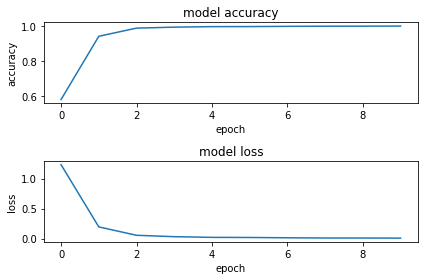

In [9]:
#this plots the training accuracy and loss over time - ONLY FOR TEACHER-FORCING MODEL
plt.figure(1)
#summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [10]:
#####Exports model for later use -- commented out for use with the restart-and-rerun notebook command
#####I don't want to accidentally save over my good model with a worse one
#model_json = model.to_json()

#with open('model76pctrue.json', 'w') as json_file:
#    json_file.write(model_json)
#
#model.save_weights("model76pctrue.h5")
#print("Saved Model to Disk")

In [11]:
#####Exports encoder and decoder networks for later use -- 
#####commented out for use with the restart-and-rerun notebook command
#####I don't want to accidentally save over my good model with a worse one

#encoder_json = encoder.to_json()
#with open('enc76pc.json', 'w') as json_file:
#    json_file.write(encoder_json)
#    
#encoder.save_weights("encoder76pc.h5")
#decoder_json = decoder.to_json()
#with open('dec76pc.json', 'w') as json_file:
#    json_file.write(decoder_json)
#    
#decoder.save_weights("decoder76pc.h5")